# nibabel
NIfTI(Neuroimaging Informatics Technology Initiative)をPythonで扱う。  
NIfTI(ニフティ)は主に脳のMRI画像のデータ形式に使われている。脳以外にもCTのデータにも使われる。

In [66]:
# nibabel（ナイバボーと読む）
import nibabel as nib
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# ファイルパス情報読み込み
df = pd.read_csv('../tqdm/covid19_im_msk_filepath.csv')
df

,path_im,filename,path_msk
0,../../sample_data/public_covid_data/rp_im/4.nii,4.nii,../../sample_data/public_covid_data/rp_msk/4.nii
1,../../sample_data/public_covid_data/rp_im/1.nii,1.nii,../../sample_data/public_covid_data/rp_msk/1.nii
2,../../sample_data/public_covid_data/rp_im/8.nii,8.nii,../../sample_data/public_covid_data/rp_msk/8.nii
3,../../sample_data/public_covid_data/rp_im/9.nii,9.nii,../../sample_data/public_covid_data/rp_msk/9.nii
4,../../sample_data/public_covid_data/rp_im/6.nii,6.nii,../../sample_data/public_covid_data/rp_msk/6.nii
5,../../sample_data/public_covid_data/rp_im/5.nii,5.nii,../../sample_data/public_covid_data/rp_msk/5.nii
6,../../sample_data/public_covid_data/rp_im/7.nii,7.nii,../../sample_data/public_covid_data/rp_msk/7.nii
7,../../sample_data/public_covid_data/rp_im/3.nii,3.nii,../../sample_data/public_covid_data/rp_msk/3.nii
8,../../sample_data/public_covid_data/rp_im/2.nii,2.nii,../../sample_data/public_covid_data/rp_msk/2.nii


In [8]:
# NIfTIファイルを読み込む
path = df['path_im'].iloc[0]
im_nifti = nib.load(path)
im_nifti

In [18]:
# 読み込んだデータをnumpy arrayとして取り出す
data = im_nifti.get_fdata()

In [12]:
data

memmap([[[-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123],
         [-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123],
         [-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123],
         ...,
         [-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123],
         [-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123],
         [-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123]],

        [[-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123],
         [-1341.1151123, -1341.1151123, -1341.1151123, ...,
          -1341.1151123, -1341.1151123, -1341.1151123],
         [-1341.1151123, -1341.1151123, -1341.1151123, .

In [13]:
data.shape

(630, 630, 39)

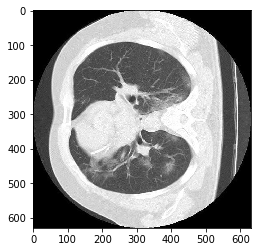

In [21]:
plt.imshow(data[:, :, 20], cmap='gray')

このnumpy arrayはshapeが(width, height, z（断面）)になっている。  
CTは通常人の足側から頭に向けた断面となる。  
画面の左側は患者の右側、画面の右側は患者の左側になる。  
右側の線はCTの台なので、本当はこれが下に来るのが正しいので修正が必要。


In [28]:
# transposeで軸を変える
data_t = np.transpose(data)

In [23]:
data_t.shape

(39, 630, 630)

一般にtransposeするとshapeの順序（軸、次元の順序）が入れ替わり、(a, b, c)→(c, b, a)のようになる。  
transposeすることにより、元のshape(630, 630, 39)が(39, 630, 630)となる。  
これは図の横軸と縦軸が入れ替わることに相当する。（図全体が左に90度回転するイメージ）

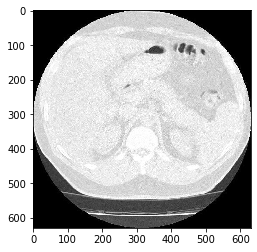

In [25]:
plt.imshow(data_t[0, :, :], cmap='gray')

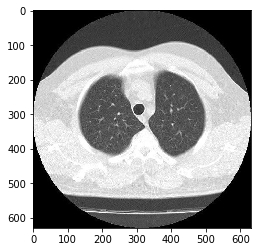

In [38]:
#上記をまとめて関数にする
def load_nifti(path):
    # 指定pathのniftiファイルを読み込み、numpy arrayの転置を返す
    return np.transpose(nib.load(path).get_fdata())

# 下記でも可。
# load_nifti = lambda x: np.transpose(nib.load(x).get_fdata())

path_im = df['path_im'].iloc[0]
data_im = load_nifti(path_im)
plt.imshow(data_im[30, :, :], cmap='gray')

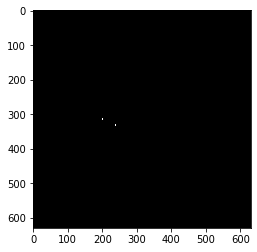

In [45]:
path_msk = df['path_msk'].iloc[0]
data_msk = load_nifti(path_msk)
# data_msk[30]だけでもOK
plt.imshow(data_msk[30, :, :], cmap='gray')

病変箇所をラベリングしている。病変箇所は白い点。

In [41]:
# mskには下記の数値しかない。
np.unique(data_msk)

array([0., 1., 2.])

In [44]:
np.unique(data_msk[30])

array([0., 1.])

In [67]:
# dfにslice数のカラムを追加
# あらかじめ df['slice_num'] = np.nanでカラムを作っておくとよいかも
slice_num = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    #path_im = df['path_im'].iloc[idx]　→なくてよい
    data_im = load_nifti(row['path_im'])
    slice_num.append(data_im.shape[0])
    # df.loc[idx, 'slice_num']で直接セルに入れることも可能。

    
df['slice_num'] = slice_num
df

100%|██████████| 9/9 [00:01<00:00,  6.57it/s]


,path_im,filename,path_msk,slice_num
0,../../sample_data/public_covid_data/rp_im/4.nii,4.nii,../../sample_data/public_covid_data/rp_msk/4.nii,39
1,../../sample_data/public_covid_data/rp_im/1.nii,1.nii,../../sample_data/public_covid_data/rp_msk/1.nii,45
2,../../sample_data/public_covid_data/rp_im/8.nii,8.nii,../../sample_data/public_covid_data/rp_msk/8.nii,45
3,../../sample_data/public_covid_data/rp_im/9.nii,9.nii,../../sample_data/public_covid_data/rp_msk/9.nii,93
4,../../sample_data/public_covid_data/rp_im/6.nii,6.nii,../../sample_data/public_covid_data/rp_msk/6.nii,42
5,../../sample_data/public_covid_data/rp_im/5.nii,5.nii,../../sample_data/public_covid_data/rp_msk/5.nii,66
6,../../sample_data/public_covid_data/rp_im/7.nii,7.nii,../../sample_data/public_covid_data/rp_msk/7.nii,42
7,../../sample_data/public_covid_data/rp_im/3.nii,3.nii,../../sample_data/public_covid_data/rp_msk/3.nii,418
8,../../sample_data/public_covid_data/rp_im/2.nii,2.nii,../../sample_data/public_covid_data/rp_msk/2.nii,39


In [62]:
# １セルから値をとりたいときによく使う
df.loc[0, 'slice_num']

39

In [61]:
# mskは全て39
slice_num2 = []
for idx, row in df.iterrows():
    #path_im = df['path_im'].iloc[idx]
    data_msk = load_nifti(row['path_msk'])
    slice_num2.append(data_im.shape[0])

print(slice_num2)

[39, 39, 39, 39, 39, 39, 39, 39, 39]


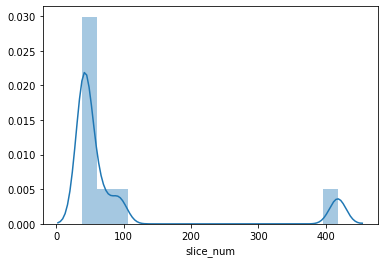

In [68]:
sns.distplot(df['slice_num'])